# Process data from sampling to computable data

add new samples files into the existing working directory

In [1]:
import cv2
import os
from openpyxl import Workbook, load_workbook
import re
from tqdm import tqdm
import shutil
from matplotlib import pyplot as plt
from matplotlib import cm as cm


sample_path = r"C:\Users\pitit\Documents\02_MUIC_programming\ICPY_441_Senior_project_in_physics\plasmaColumnPosition\resources\Sampling"
# folders = [os.path.join(sample_path, f) for f in os.listdir(sample_path) if os.path.isdir(os.path.join(sample_path, f))]

## video to frames

In [11]:
def extract_frames(shot_no,video_path, output_folder):
    """
    Extracts each frame from a video and saves it as a JPEG image.

    Args:
        video_path: Path to the input video file.
        output_folder: Path to the folder where the extracted frames will be saved.
    """

    output_folder = output_folder + f"{shot_no}"

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        shutil.copy(video_path,output_folder)

        os.makedirs(os.path.join(output_folder, f"{shot_no}_frames_jpg"))

    video_capture = cv2.VideoCapture(video_path)
    frame_count = 1  # Start counting from 1

    while True:
        success, frame = video_capture.read()
        if not success:
            break

        output_path = os.path.join(output_folder, f"{shot_no}_frames_jpg\{frame_count}.jpg")
        cv2.imwrite(output_path, frame)
        frame_count += 1
    video_capture.release()


#extract videos
all_videos = []
shot_nos = []
for f in folders:
    fname = [vid.split(sep = ".")[0] for vid in os.listdir(f) if vid.lower().endswith(".avi")]
    fvideos = [os.path.join(f,vid) for vid in os.listdir(f) if vid.lower().endswith(".avi")]
    shot_nos.extend(fname)
    all_videos.extend(fvideos)

TT1_frame_dir = r"C:\Users\pitit\Documents\02_MUIC_programming\ICPY_441_Senior_project_in_physics\plasmaColumnPosition\resources\TTI frame\\"
for i in range(len(all_videos)):
    extract_frames(shot_nos[i],all_videos[i],TT1_frame_dir)

<string>:27: SyntaxWarning: invalid escape sequence '\{'
<>:27: SyntaxWarning: invalid escape sequence '\{'
<string>:27: SyntaxWarning: invalid escape sequence '\{'
<>:27: SyntaxWarning: invalid escape sequence '\{'
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_144128\2876241390.py:27: SyntaxWarning: invalid escape sequence '\{'
  output_path = os.path.join(output_folder, f"{shot_no}_frames_jpg\{frame_count}.jpg")


C:\Users\pitit\Documents\02_MUIC_programming\ICPY_441_Senior_project_in_physics\plasmaColumnPosition\resources\TTI frame\\1108\1108_frames_jpg
C:\Users\pitit\Documents\02_MUIC_programming\ICPY_441_Senior_project_in_physics\plasmaColumnPosition\resources\TTI frame\\1275\1275_frames_jpg
C:\Users\pitit\Documents\02_MUIC_programming\ICPY_441_Senior_project_in_physics\plasmaColumnPosition\resources\TTI frame\\1745\1745_frames_jpg
C:\Users\pitit\Documents\02_MUIC_programming\ICPY_441_Senior_project_in_physics\plasmaColumnPosition\resources\TTI frame\\1804\1804_frames_jpg
C:\Users\pitit\Documents\02_MUIC_programming\ICPY_441_Senior_project_in_physics\plasmaColumnPosition\resources\TTI frame\\2308\2308_frames_jpg
C:\Users\pitit\Documents\02_MUIC_programming\ICPY_441_Senior_project_in_physics\plasmaColumnPosition\resources\TTI frame\\370\370_frames_jpg
C:\Users\pitit\Documents\02_MUIC_programming\ICPY_441_Senior_project_in_physics\plasmaColumnPosition\resources\TTI frame\\433\433_frames_jpg
C:\

## Toroidal Filament

In [4]:
#read time and measurement from text files
def txt_to_list(path):

    def is_float_digit(n: str) -> bool:
     try:
         float(n)
         return True
     except ValueError:
         return False
     
    time_arr, data_arr = [], []
    shot_no = None
    with open(path, "r") as file:
        for line in file:
            if line.strip():  # Ignore empty lines
                parts = line.split()
                if parts[0] == "ShotNo": shot_no = int(parts[2])
                if not is_float_digit(parts[0]): continue

                time, data = float(parts[0]), float(parts[1])
                
                time_arr.append(time)
                data_arr.append(data)

    return shot_no, time_arr, data_arr

### Plasma current

In [ ]:
IP_spreadsheet = r"C:\Users\pitit\Documents\02_MUIC_programming\ICPY_441_Senior_project_in_physics\plasmaColumnPosition\resources\magneticSignal\Plasma current for plasma position.xlsx"
wb = load_workbook(IP_spreadsheet)

ws = wb["Sheet1"]

#plasma current for each shots
all_IP1 = []
for f in folders:
    ip1_path = os.path.join(f, "IP1.txt")
    if os.path.isfile(ip1_path):
        all_IP1.append(ip1_path)
    else: raise FileNotFoundError(f"{ip1_path} does not exist")

#sort from smallest to largest shot number
all_IP1 = sorted(all_IP1, key=lambda path: int(os.path.basename(os.path.dirname(path))))

In [ ]:
#function to write values into the plasma current spreadsheet
def edit_IP_spreadsheet(ws,IP_path,column):
    shot_no,_, IP_data = txt_to_list(IP_path)
    ws.cell(row = 1,column=column).value = shot_no

    for row, plasma_current in enumerate(IP_data,start = 2):
        ws.cell(row = row, column = column).value = plasma_current
    
    wb.save(IP_spreadsheet)

column = 9
for i in range(len(all_IP1)):
    edit_IP_spreadsheet(ws,all_IP1[i],column)
    column += 1

### Magnetic probe signal

In [2]:
workbook_path = r"resources\magneticSignal\Magnetic probe GBP_T for plasma position.xlsx"
workbook = load_workbook(workbook_path)

In [35]:
def new_shot_signal(workbook,workbook_path,dir_path):
    shot_no = os.path.basename(dir_path)
    new_sheet = workbook.create_sheet(title=f"shot_{shot_no}")

    #extract signal at each probes
    signal_files = [os.path.join(dir_path,file) for file in os.listdir(dir_path) if file[:3] == "GBP" and (file[4] == "T" or file[5] == "T")]

    def extract_number(filename): #function to sort list by probe numbers
        match = re.search(r'GBP(\d+)[Tt]', filename)
        return int(match.group(1)) if match else float('inf')
    
    #sort signals by probe numbers
    signal_files = sorted(signal_files, key=lambda path: extract_number(os.path.basename(path)))

    #create header of new sheet
    headers = ["Time (ms)"] + ["GBP" + f"{i}" + "T" for i in range(1,13)]

    for i, head in enumerate(headers, start = 1):
        new_sheet.cell(row = 1, column = i).value = head

    #fill in values of each columns

    #time column
    _, time, _ = txt_to_list(signal_files[0])

    for row, t in enumerate(time, start = 2):
        new_sheet.cell(row=row,column=1).value = t

    #signal columns
    for i in range(len(signal_files)):
        _, _, all_time_signal = txt_to_list(signal_files[i])
        
        for row, signal in enumerate(all_time_signal,start = 2):
            new_sheet.cell(row=row,column=i+2).value = signal

    workbook.save(workbook_path)

for f in tqdm(folders):
    new_shot_signal(workbook,workbook_path,f)

100%|██████████| 13/13 [22:15<00:00, 102.76s/it]


# Edit values in excel to have correct sign

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_7240\1213657484.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab20",len(keys))


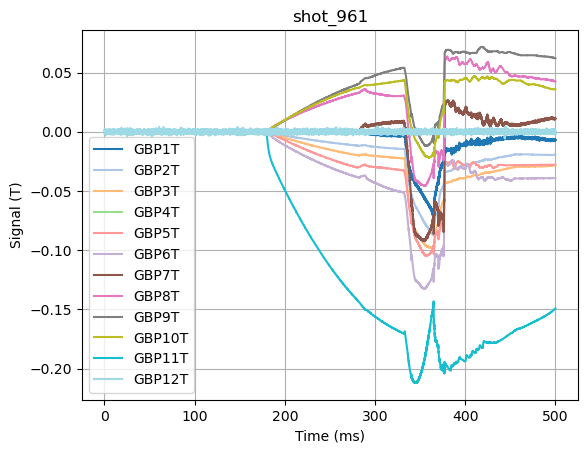

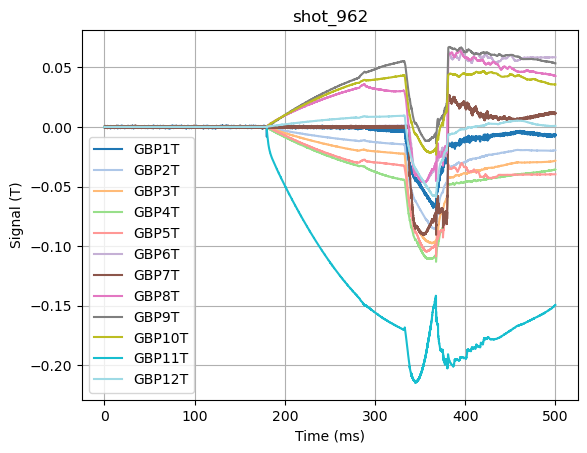

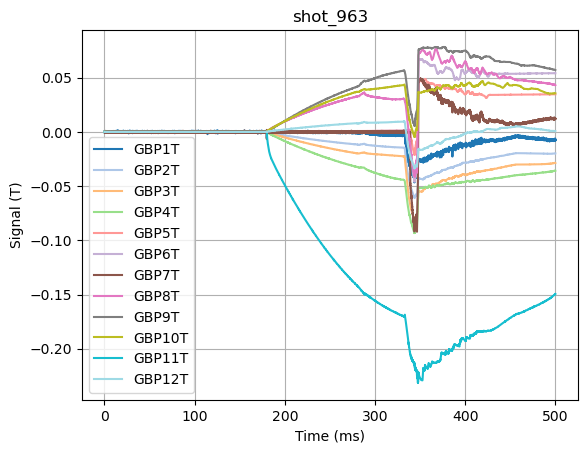

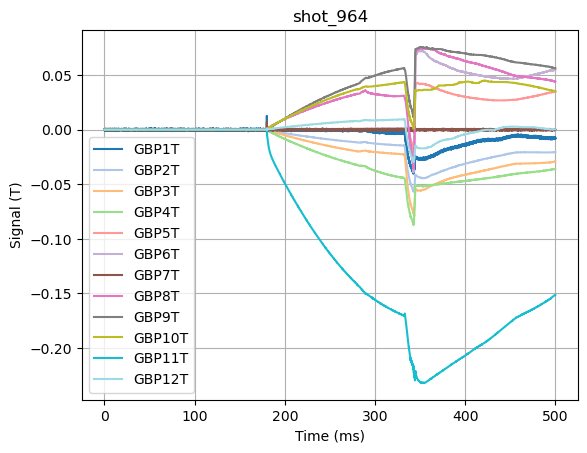

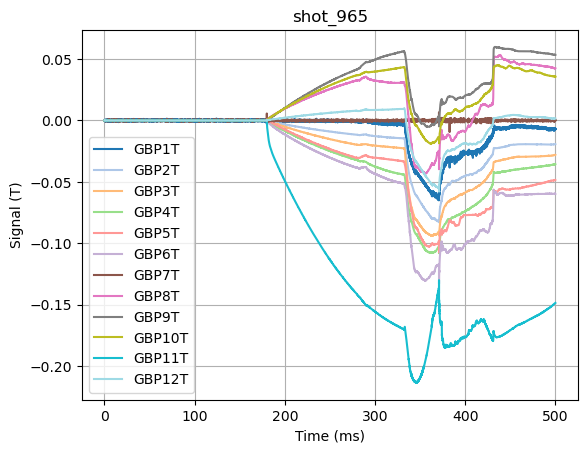

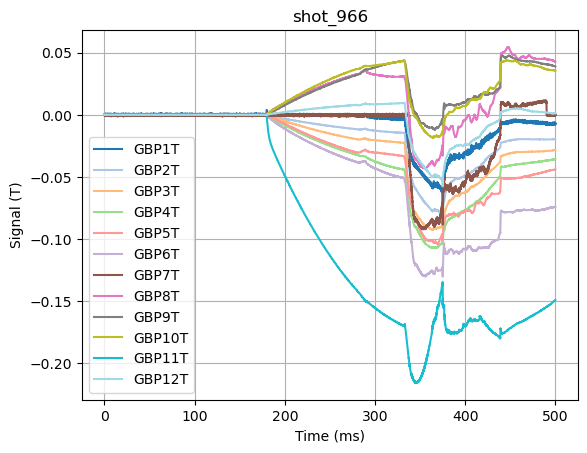

KeyboardInterrupt: 

In [3]:
# plot signals
sheet_names = workbook.sheetnames
for sheet_name in sheet_names:
    excel_sheet = workbook[sheet_name]

    header_row = excel_sheet[1]
    header_map = {cell.value: cell.column for cell in header_row}

    def extract_column(sheet,column_name):
        col_idx = header_map.get(column_name)
        if col_idx is None:
            raise ValueError(f"Column '{column_name}' not found.")
        
        # Get values from row 2 onward (skip header)
        values = [
            sheet.cell(row=row, column=col_idx).value
            for row in range(2, sheet.max_row + 1)
        ]
        return values

    time = extract_column(excel_sheet,"Time (ms)")

    signal_dict = {}

    for header in header_map.keys():
        if header == "Time (ms)": continue
        signal_dict[header] = extract_column(excel_sheet,header)

    keys = signal_dict.keys()

    fig, ax = plt.subplots(1)
    colors = cm.get_cmap("tab20",len(keys))

    for i,key in enumerate(keys):
        ax.plot(time,signal_dict[key],label = key,color = colors(i))
    ax.set_title(sheet_name)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Signal (T)")
    ax.grid()
    ax.legend()
    plt.show()


In [6]:
def flip_signals(excel_sheet,column_names):

    headers = {cell.value: cell.column for cell in excel_sheet[1]}

    for col_name in column_names:
        if col_name not in headers:
            raise ValueError(f"Column {col_name} not found in sheet.")

        col_idx = headers[col_name]

        for row in range(2, excel_sheet.max_row + 1):
            cell = excel_sheet.cell(row=row, column=col_idx)
            if isinstance(cell.value, (int,float)):
                cell.value *= -1
    
    return

#dictionary of probes that require flipping for each frames
adjustment_dict = {
    433: [10,11], 582: [10], 665:[10,11],920:[8,9,11],926:[10,11],928:[11],969:[10,11]
}

for i in range(961,968):
    adjustment_dict[i] = [10,11]

for shot_no in adjustment_dict.keys():
    sheet_name = "shot_" + str(shot_no)
    excel_sheet = workbook[sheet_name]

    column_names = [f"GBP{i}T" for i in adjustment_dict[shot_no]]
    flip_signals(excel_sheet,column_names)

In [7]:
workbook.save(filename=workbook_path)